# Executive Summary
* A startup that operates in the microlending space would like to understand what types of people make microloans
* Relevant information on microlenders is publically available through an API provided by Kiva, the world's largest microlending service
* A startup asked me to mine Kiva data to identify, characterize, and quantify key microlender segments
* Using the outputs from this analysis, this startup will map customer profiles to consumption patterns
* Results of this analysis showed xxx

# Methodology
1. Download json files of all public lenders that provides name, occupation, location, number of loans, and other information
  * Join all datafiles into one readable file
2. Estimate subset of public lenders needed for a sufficiently representative sample
3. Wrangle lender data
4. Join loan data to lender data to create one flat table
5. Clean up and standardize data
6. Analyze data to identify key customer attributes and from that create customer segments

# Kiva Data Sources / API Call Examples
* Snapshot of lender data http://build.kiva.org/docs/data/snapshots
* Call lender loans http://api.kivaws.org/v1/lenders/jeremy/loans.json

# Assumptions
* Alpha = 5% (threshold for p-value)

# Modules

In [3]:
import pandas as pd
import json
import requests
import re
import os
import math
import random
import numpy as np
from datetime import datetime
import time
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
%matplotlib inline
from patsy import dmatrices

/Users/peter/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


# 1. Download list of json files
* Snapshot of lender data http://build.kiva.org/docs/data/snapshots
* Retrieved 2016-04-06

# 2. Estimate sample size
* Formula per https://www.unc.edu/~rls/s151-2010/class23.pdf
* Sample Size = std_dev * (1-std_dev) * (z_score / error)^2
* Assume 99% confidence (z score of 2.576), standard deviation of 0.5, and a margin of error of 1%

In [4]:
# Sample size inputs

z_score = 2.576 # 1.96 for 95% confidence, 2.576 for 99% confidence
std_dev = 0.5 # Do not know standard deviation so selected conservative estimate
error = 0.01 # 5% margin of error 

In [5]:
def nec_sample_size(z_score, std_dev, error):
    nec_sample_size = std_dev * (1-std_dev) * (z_score/error)**2
    return nec_sample_size

sample_size = int(math.ceil(nec_sample_size(z_score, std_dev, error)))
sample_size

16590

# 3. Wrangle lender data

In [6]:
# Fix json data
#path = '/Users/peter/ds/metis/notebooks/projects/investigation 1/lenders'
#json_data = ''
#base = 94
#for path, dirs, files in os.walk(path):
#    for file_name in files:
#        if file_name[-4:] == 'json':
#            fullpath = os.path.join(path, file_name)
#            with open(fullpath, 'r') as f:
#                 file_number = int(file_name[:-5])
#                 json_data = f.read()
#            offset = int(math.log(file_number,10))
#            start_point = base + offset
#            json_data = json_data[start_point:]
#            json_data = json_data[:-1]
#            with open(fullpath, 'w') as f:
#                f.write(json_data)

In [7]:
# Use random number generator to sample json files
# Number of json files equals sample size
json_files = 1860/2 # This is the number of Kiva users in the json files divided by two
entries_per_json_file = 1000
selected_files = np.random.randint(1,json_files, sample_size)
selected_files = map(str, selected_files)
selected_entries = np.random.choice(entries_per_json_file, sample_size)
files_entries = zip(selected_files, selected_entries)
files_entries[:10]

[('833', 397),
 ('541', 813),
 ('31', 786),
 ('337', 575),
 ('210', 106),
 ('711', 754),
 ('647', 635),
 ('244', 262),
 ('696', 306),
 ('25', 674)]

In [8]:
# Make a list of sampled persons
the_list = []
json_data = ''
for the_tuple in files_entries:
    file_name = 'lenders/' + the_tuple[0] + '.json'    
    with open(file_name) as json_file:
        d = []
        d = list(json.load(json_file))
        the_entry = d[the_tuple[1]]
        the_list.append(the_entry)

In [9]:
# Convert list to dataframe and remove image column
df = pd.DataFrame(the_list)
df.drop(df.columns[1], axis=1, inplace=True)

In [10]:
# Get rid of unicode characters
df['member_start'] =df['member_since'].astype(str).str.split(',')

In [11]:
# Add the date column
join_date = []
for i in df.member_start:
    join_date.append(i[0][:10])

for i in join_date:
    i = datetime.strptime(i, '%Y-%m-%d')

join_date = map(lambda x: datetime.strptime(x, '%Y-%m-%d'), join_date)
join_year = map(lambda x: x.year + float(x.month)/12 + float(x.day)/365, join_date)
join_year = pd.Series(join_year, name='join_year')
df['join_year'] = join_year
df.head(3)

,country_code,invitee_count,inviter_id,lender_id,loan_because,loan_count,member_since,name,occupation,occupational_info,personal_url,uid,whereabouts,member_start,join_year
0,US,0,None,kristin2273,,2,2011-08-06T20:16:03Z,Kristin,,,,kristin2273,Washington District of Columbia,[2011-08-06T20:16:03Z],2011.683105
1,US,1,None,charles7164,,0,2009-12-23T18:59:33Z,Charles,Student,,,charles7164,Charlottesville VA,[2009-12-23T18:59:33Z],2010.063014
2,US,0,None,katharine2239,,41,2007-03-18T15:24:40Z,Katharine,,,,katharine2239,Chicago IL,[2007-03-18T15:24:40Z],2007.299315


In [12]:
# Encode as unicode strings
# https://docs.python.org/2/library/codecs.html

df['name']=[unicode(s).encode("utf-8") for s in df['name']]
df['country_code']=[unicode(s).encode("utf-8") for s in df['country_code']]
df['whereabouts']=[unicode(s).encode("utf-8") for s in df['whereabouts']]
df['occupation']=[unicode(s).encode("utf-8") for s in df['occupation']]
df['occupational_info']=[unicode(s).encode("utf-8") for s in df['occupational_info']]
df['inviter_id']=[unicode(s).encode("utf-8") for s in df['inviter_id']]
df['loan_because']=[unicode(s).encode("utf-8") for s in df['loan_because']]

In [13]:
# Lower case key string columns

df.name = df.name.str.lower()
df.country_code = df.country_code.str.lower()
df.whereabouts = df.whereabouts.str.lower()
df.occupation = df.occupation.str.lower()
df.occupational_info = df.occupational_info.str.lower()
df.inviter_id = df.inviter_id.str.lower()
df.loan_because = df.loan_because.str.lower()
df.head(3)

,country_code,invitee_count,inviter_id,lender_id,loan_because,loan_count,member_since,name,occupation,occupational_info,personal_url,uid,whereabouts,member_start,join_year
0,us,0,none,kristin2273,,2,2011-08-06T20:16:03Z,kristin,,,,kristin2273,washington district of columbia,[2011-08-06T20:16:03Z],2011.683105
1,us,1,none,charles7164,,0,2009-12-23T18:59:33Z,charles,student,,,charles7164,charlottesville va,[2009-12-23T18:59:33Z],2010.063014
2,us,0,none,katharine2239,,41,2007-03-18T15:24:40Z,katharine,,,,katharine2239,chicago il,[2007-03-18T15:24:40Z],2007.299315


In [14]:
# Add years that user has been part of Kiva
#import datetime # import datetime again
year_retrieved = 2016.0 + 3.0/12 + 1.0/365
df['years_active'] = year_retrieved - df['join_year']
df.head(3)

,country_code,invitee_count,inviter_id,lender_id,loan_because,loan_count,member_since,name,occupation,occupational_info,personal_url,uid,whereabouts,member_start,join_year,years_active
0,us,0,none,kristin2273,,2,2011-08-06T20:16:03Z,kristin,,,,kristin2273,washington district of columbia,[2011-08-06T20:16:03Z],2011.683105,4.569635
1,us,1,none,charles7164,,0,2009-12-23T18:59:33Z,charles,student,,,charles7164,charlottesville va,[2009-12-23T18:59:33Z],2010.063014,6.189726
2,us,0,none,katharine2239,,41,2007-03-18T15:24:40Z,katharine,,,,katharine2239,chicago il,[2007-03-18T15:24:40Z],2007.299315,8.953425


In [15]:
# Calculate loan activity as quotient of loans and years active
df['loans_year'] =(df.loan_count) / (df.years_active)
df.head(3)

,country_code,invitee_count,inviter_id,lender_id,loan_because,loan_count,member_since,name,occupation,occupational_info,personal_url,uid,whereabouts,member_start,join_year,years_active,loans_year
0,us,0,none,kristin2273,,2,2011-08-06T20:16:03Z,kristin,,,,kristin2273,washington district of columbia,[2011-08-06T20:16:03Z],2011.683105,4.569635,0.437672
1,us,1,none,charles7164,,0,2009-12-23T18:59:33Z,charles,student,,,charles7164,charlottesville va,[2009-12-23T18:59:33Z],2010.063014,6.189726,0.000000
2,us,0,none,katharine2239,,41,2007-03-18T15:24:40Z,katharine,,,,katharine2239,chicago il,[2007-03-18T15:24:40Z],2007.299315,8.953425,4.579253


In [16]:
# Calculate invitation activity as quotient of invitations and years active
df['invites_year'] =(df.invitee_count) / (df.years_active)
df.head(3)

,country_code,invitee_count,inviter_id,lender_id,loan_because,loan_count,member_since,name,occupation,occupational_info,personal_url,uid,whereabouts,member_start,join_year,years_active,loans_year,invites_year
0,us,0,none,kristin2273,,2,2011-08-06T20:16:03Z,kristin,,,,kristin2273,washington district of columbia,[2011-08-06T20:16:03Z],2011.683105,4.569635,0.437672,0.000000
1,us,1,none,charles7164,,0,2009-12-23T18:59:33Z,charles,student,,,charles7164,charlottesville va,[2009-12-23T18:59:33Z],2010.063014,6.189726,0.000000,0.161558
2,us,0,none,katharine2239,,41,2007-03-18T15:24:40Z,katharine,,,,katharine2239,chicago il,[2007-03-18T15:24:40Z],2007.299315,8.953425,4.579253,0.000000


In [17]:
# Calculate whether person was invited
df['invited'] = 0
df.loc[df['inviter_id'] != 'none', 'invited'] = 1
df.head(3)

,country_code,invitee_count,inviter_id,lender_id,loan_because,loan_count,member_since,name,occupation,occupational_info,personal_url,uid,whereabouts,member_start,join_year,years_active,loans_year,invites_year,invited
0,us,0,none,kristin2273,,2,2011-08-06T20:16:03Z,kristin,,,,kristin2273,washington district of columbia,[2011-08-06T20:16:03Z],2011.683105,4.569635,0.437672,0.000000,0
1,us,1,none,charles7164,,0,2009-12-23T18:59:33Z,charles,student,,,charles7164,charlottesville va,[2009-12-23T18:59:33Z],2010.063014,6.189726,0.000000,0.161558,0
2,us,0,none,katharine2239,,41,2007-03-18T15:24:40Z,katharine,,,,katharine2239,chicago il,[2007-03-18T15:24:40Z],2007.299315,8.953425,4.579253,0.000000,0


In [18]:
# Calculate whether lender entered a reason for lending
df['lending_reason'] = df['loan_because'].str.len()
df.head(3)

,country_code,invitee_count,inviter_id,lender_id,loan_because,loan_count,member_since,name,occupation,occupational_info,personal_url,uid,whereabouts,member_start,join_year,years_active,loans_year,invites_year,invited,lending_reason
0,us,0,none,kristin2273,,2,2011-08-06T20:16:03Z,kristin,,,,kristin2273,washington district of columbia,[2011-08-06T20:16:03Z],2011.683105,4.569635,0.437672,0.000000,0,0
1,us,1,none,charles7164,,0,2009-12-23T18:59:33Z,charles,student,,,charles7164,charlottesville va,[2009-12-23T18:59:33Z],2010.063014,6.189726,0.000000,0.161558,0,0
2,us,0,none,katharine2239,,41,2007-03-18T15:24:40Z,katharine,,,,katharine2239,chicago il,[2007-03-18T15:24:40Z],2007.299315,8.953425,4.579253,0.000000,0,0


In [19]:
# Assign gender to each record
# Import csv of names and associated genders
df_gender = pd.DataFrame.from_csv('names.csv')
df_gender=df_gender.reset_index()
df_gender['name'] = df_gender['name'].str.lower()
df_gender.head(3)

,name,gender
0,aaden,male
1,aaliyah,female
2,aarav,male


In [20]:
# Assign region to each record
# Import csv of iso codes and associated regions
df_region = pd.DataFrame.from_csv('iso_countries.csv')
df_region=df_region.reset_index()
df_region['country_code'] = df_region['country_code'].str.lower()
df_region.head(3)

,country_code,region
0,af,Rest of World
1,al,Rest of World
2,dz,Rest of World


In [21]:
# Merge gender and region

#type(df_gender['name'][0])
df = pd.merge(df, df_gender, how='left', on='name')
df = pd.merge(df, df_region, how='left', on='country_code')
df.head(3)

,country_code,invitee_count,inviter_id,lender_id,loan_because,loan_count,member_since,name,occupation,occupational_info,...,whereabouts,member_start,join_year,years_active,loans_year,invites_year,invited,lending_reason,gender,region
0,us,0,none,kristin2273,,2,2011-08-06T20:16:03Z,kristin,,,...,washington district of columbia,[2011-08-06T20:16:03Z],2011.683105,4.569635,0.437672,0.000000,0,0,male,US & Canada
1,us,1,none,charles7164,,0,2009-12-23T18:59:33Z,charles,student,,...,charlottesville va,[2009-12-23T18:59:33Z],2010.063014,6.189726,0.000000,0.161558,0,0,male,US & Canada
2,us,0,none,katharine2239,,41,2007-03-18T15:24:40Z,katharine,,,...,chicago il,[2007-03-18T15:24:40Z],2007.299315,8.953425,4.579253,0.000000,0,0,female,US & Canada


In [22]:
# Filter out NaN genders
gender_filter = df['gender'].notnull()
df = df[gender_filter]
df.head(3)

,country_code,invitee_count,inviter_id,lender_id,loan_because,loan_count,member_since,name,occupation,occupational_info,...,whereabouts,member_start,join_year,years_active,loans_year,invites_year,invited,lending_reason,gender,region
0,us,0,none,kristin2273,,2,2011-08-06T20:16:03Z,kristin,,,...,washington district of columbia,[2011-08-06T20:16:03Z],2011.683105,4.569635,0.437672,0.000000,0,0,male,US & Canada
1,us,1,none,charles7164,,0,2009-12-23T18:59:33Z,charles,student,,...,charlottesville va,[2009-12-23T18:59:33Z],2010.063014,6.189726,0.000000,0.161558,0,0,male,US & Canada
2,us,0,none,katharine2239,,41,2007-03-18T15:24:40Z,katharine,,,...,chicago il,[2007-03-18T15:24:40Z],2007.299315,8.953425,4.579253,0.000000,0,0,female,US & Canada


In [23]:
# Import csv of vocations
df_vocation = pd.DataFrame.from_csv('vocations.1.csv')
df_vocation=df_vocation.reset_index()
df_vocation['tech_science'] = df_vocation['tech_science'].str.lower()
df_vocation['ngo'] = df_vocation['ngo'].str.lower()
df_vocation['retiree'] = df_vocation['retiree'].str.lower()
df_vocation.head(3)

,occupation,tech_science,ngo,retiree
0,under,no,no,no
1,unemploy,no,no,no
2,retire,no,no,yes


In [24]:
def zip_lists(df, col_name1, col_name2):
    return_list = zip(df[col_name1],df[col_name2])
    return return_list

occupation_tech_list = zip_lists(df_vocation, 'occupation', 'tech_science')
occupation_ngo_list = zip_lists(df_vocation, 'occupation', 'ngo')
occupation_retiree_list = zip_lists(df_vocation, 'occupation', 'retiree')

In [25]:
# map join attributes on occupation

def str_contain(string, pattern):
    compiled_pattern = re.compile(pattern)
    return compiled_pattern.search(string)

def map_list_2_df(df, df_col_name_2_map, list_2_map, df_col_2_create):
    word = ''
    appended_list = []
    for occupation in df[df_col_name_2_map].iteritems():
        for the_tuple in list_2_map:
            if str_contain(occupation[1], the_tuple[0]):
                word = the_tuple[1]
        appended_list.append(word)
    the_series = pd.Series(appended_list)
    df.loc[:,df_col_2_create]=pd.Series(appended_list, index=df.index)        

map_list_2_df(df, 'occupation', occupation_tech_list, 'tech_science')
map_list_2_df(df, 'occupation', occupation_ngo_list, 'ngo')
map_list_2_df(df, 'occupation', occupation_retiree_list, 'retiree')

df.head(3)

,country_code,invitee_count,inviter_id,lender_id,loan_because,loan_count,member_since,name,occupation,occupational_info,...,years_active,loans_year,invites_year,invited,lending_reason,gender,region,tech_science,ngo,retiree
0,us,0,none,kristin2273,,2,2011-08-06T20:16:03Z,kristin,,,...,4.569635,0.437672,0.000000,0,0,male,US & Canada,,,
1,us,1,none,charles7164,,0,2009-12-23T18:59:33Z,charles,student,,...,6.189726,0.000000,0.161558,0,0,male,US & Canada,no,no,no
2,us,0,none,katharine2239,,41,2007-03-18T15:24:40Z,katharine,,,...,8.953425,4.579253,0.000000,0,0,female,US & Canada,no,no,no


In [26]:
def filter_not_equal(df, df_col, criterion):
    the_filter = df[df_col] != criterion
    df = df[the_filter]
    return df

def filter_not_contains(df, df_col, criterion):
    the_filter = ~df[df_col].str.contains(criterion)
    df = df[the_filter]
    return df


df = filter_not_equal(df, 'country_code', 'none')
df = filter_not_equal(df, 'country_code', '')

df = filter_not_equal(df, 'name', '')
df = filter_not_contains(df, 'name', ' and ')
df = filter_not_contains(df, 'name', 'fund')
df = filter_not_contains(df, 'name', '&')
df['name'] = df['name'].str.split(' ').str.get(0)

df = filter_not_equal(df, 'occupation', '')
df = filter_not_equal(df, 'occupation', 'other')


df = filter_not_equal(df, 'gender', '')

df = filter_not_equal(df, 'region', '')

df = filter_not_equal(df, 'tech_science', '')
#df = filter_not_equal(df, 'ngo', '')
df = filter_not_equal(df, 'retiree', '')

df.dropna(thresh=1)

df.head(3)

,country_code,invitee_count,inviter_id,lender_id,loan_because,loan_count,member_since,name,occupation,occupational_info,...,years_active,loans_year,invites_year,invited,lending_reason,gender,region,tech_science,ngo,retiree
1,us,1,none,charles7164,,0,2009-12-23T18:59:33Z,charles,student,,...,6.189726,0.000000,0.161558,0,0,male,US & Canada,no,no,no
13,us,0,none,rachel6305,,31,2007-12-24T16:59:42Z,rachel,student,,...,8.186986,3.786497,0.000000,0,0,male,US & Canada,no,no,no
19,us,1,none,william8839,,28,2009-03-09T02:30:25Z,william,construction,,...,6.978082,4.012564,0.143306,0,0,male,US & Canada,no,no,no


In [27]:
# Remove unnecessary columns
df = df.drop('invited', 1)
df = df.drop('invitee_count', 1)
df = df.drop('inviter_id', 1)
df = df.drop('lender_id', 1)
df = df.drop('loan_because', 1)
df = df.drop('member_since', 1)
df = df.drop('occupational_info', 1)
df = df.drop('uid', 1)
df = df.drop('member_start', 1)
df = df.drop('join_year', 1)
df = df.drop('personal_url', 1)
df = df.drop('loan_count', 1)
df = df.drop('name', 1)
df = df.drop('occupation', 1)
df = df.drop('whereabouts', 1)
df = df.drop('years_active', 1)
df = df.drop('country_code', 1)

df.head()

,loans_year,invites_year,lending_reason,gender,region,tech_science,ngo,retiree
1,0.000000,0.161558,0,male,US & Canada,no,no,no
13,3.786497,0.000000,0,male,US & Canada,no,no,no
19,4.012564,0.143306,0,male,US & Canada,no,no,no
29,3.898339,0.000000,0,male,US & Canada,yes,no,no
31,0.000000,0.000000,67,male,US & Canada,yes,no,no


# 3. Carry out linear regression
* Create an object
* Fit the model
* Predict

In [28]:
# Set y and random variable X
y, X = dmatrices('loans_year ~ invites_year + lending_reason + gender + region + tech_science', data=df, return_type='dataframe')

In [29]:
# See if y is represented correctly
y.head()

,loans_year
1,0.000000
13,3.786497
19,4.012564
29,3.898339
31,0.000000


In [30]:
# See if X is represented correctly
X.head()

,Intercept,gender[T.male],region[T.US & Canada],tech_science[T.yes],invites_year,lending_reason
1,1.0,1.0,1.0,0.0,0.161558,0.0
13,1.0,1.0,1.0,0.0,0.000000,0.0
19,1.0,1.0,1.0,0.0,0.143306,0.0
29,1.0,1.0,1.0,1.0,0.000000,0.0
31,1.0,1.0,1.0,1.0,0.000000,67.0


In [31]:
import statsmodels.api as sm

In [32]:
model = sm.OLS(y, X)
results = model.fit()

In [33]:
print 'type of model:', type(model)
print 'type of results:', type(results)

type of model: <class 'statsmodels.regression.linear_model.OLS'>
type of results: <class 'statsmodels.regression.linear_model.RegressionResultsWrapper'>


In [34]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             loans_year   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     38.22
Date:                Fri, 15 Apr 2016   Prob (F-statistic):           1.79e-38
Time:                        13:30:34   Log-Likelihood:                -16363.
No. Observations:                4189   AIC:                         3.274e+04
Df Residuals:                    4183   BIC:                         3.278e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                 3.7440      0.537      6.967      0.000         2.690     4.798
gender[T.male]            0.9342      0.435      2.146      0.032         0.081     1.788
region[T.US & Canada]    -2.1337      0.454     -4.702      0.000        -3.023    -1.244
tech_science[T.yes]       1.1940      0.474      2.517      0.012         0.264     2.124
invites_year              6.7211      0.616     10.918      0.000         5.514     7.928
lending_reason            0.0106      0.002      4.552      0.000         0.006     0.015
==============================================================================
Omnibus:                     7698.495   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         13984841.750
Skew:                          13.438   Prob(JB):                         0.00
Kurtosis:                     284.782   Cond. No.                         323.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
import seaborn as sns
from scipy import stats, integrate

In [36]:
x = df['loans_year']
x_list = x.values.tolist()

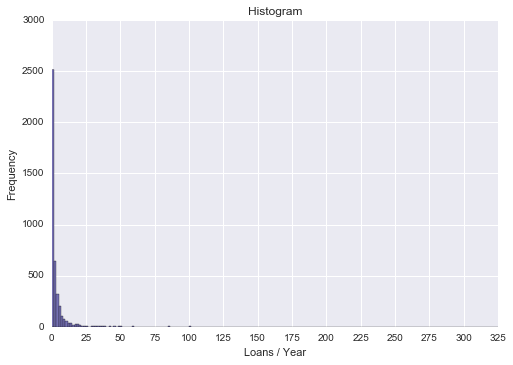

In [37]:
#plt.hist(x_list)
plt.title('Histogram')
plt.xlabel('Loans / Year')
plt.ylabel('Frequency')
plt.hist(x_list, bins=200, color='#7570b3')
plt.axis(xmin=0, xmax=100, ymin=0)
plt.rc('font', size='800')
plt.xticks(np.arange(min(x), max(x)+1, 25))
plt.show()

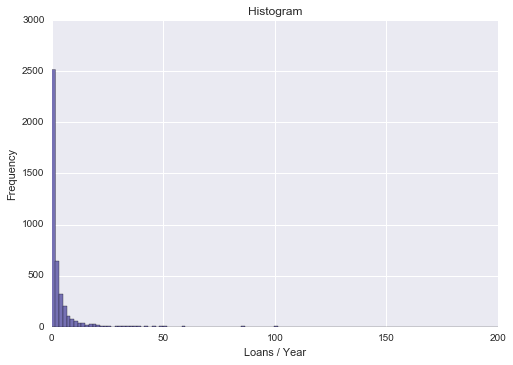

In [38]:
#plt.hist(x_list)
plt.title('Histogram')
plt.xlabel('Loans / Year')
plt.ylabel('Frequency')
plt.hist(x_list, bins=200, color='#7570b3')
plt.axis(xmin=0, xmax=200, ymin=0)

plt.rc('font', size='800')
plt.show()

In [39]:
def summary_stats(df, groupby_col, dummy_col):
    s_group = df.groupby(groupby_col).count()[dummy_col]
    s_pct = s_group / (s_group.sum())
    new_df = pd.DataFrame(pd.concat([s_group, s_pct], axis=1))
    new_df.columns = ['count', 'share']
    return new_df

In [40]:
df_gender_grp = summary_stats(df, 'gender', 'loans_year')
df_gender_grp

,count,share
gender,,
female,1018,0.243017
male,3171,0.756983


In [41]:
df_tech_grp = summary_stats(df, 'tech_science', 'loans_year')
df_tech_grp

,count,share
tech_science,,
no,3383,0.807591
yes,806,0.192409


In [42]:
df_region_grp = summary_stats(df, 'region', 'loans_year')
df_region_grp

,count,share
region,,
Rest of World,902,0.215326
US & Canada,3287,0.784674


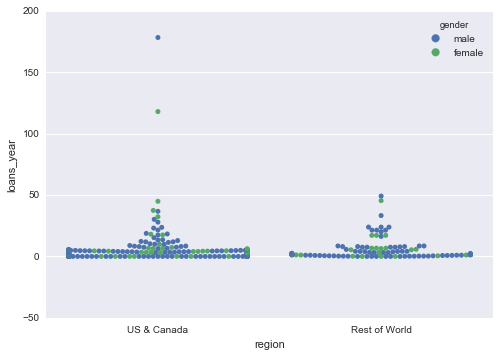

In [43]:
sns.swarmplot(x="region", y="loans_year", hue="gender", data=df.head(500))

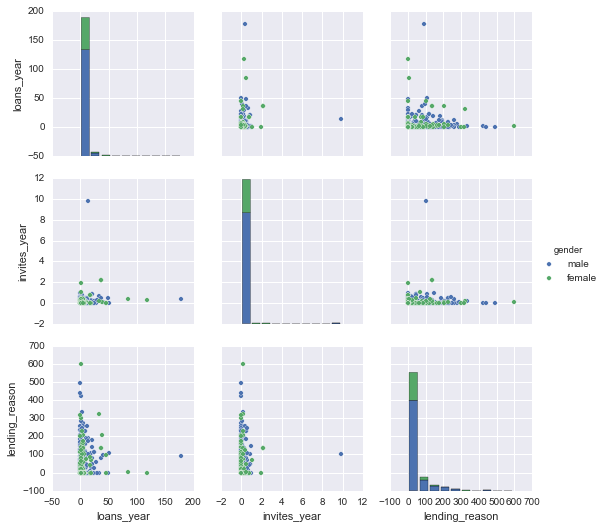

In [44]:
sns.set()

sns.pairplot(df.head(800), hue="gender")

In [45]:
df['loans_year'].mean()

3.9606229460925753

In [46]:
df['loans_year'].std()

12.299843131619287